In [1]:
import requests
import os
import sys
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import seaborn as sns

# https://stackoverflow.com/questions/34478398/import-local-function-
# from-a-module-housed-in-another-directory-with-relative-im
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import local_module as local

# Data Caveats
- Not sure which estimates to use, 1, 3, or 5-year: https://www.census.gov/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018_ch03.pdf
- 

In [2]:
# list of ACS 1-year years
years = list(range(2006, 2021))

In [3]:
means_transpo = pd.DataFrame() # initialize dataframe

for year in years:
    # Census did not release 1-year estimates for 2020
    # https://www.census.gov/data/developers/data-sets/acs-1year.2020.html
    if year == 2020:
        pass
    else:
        # build API call
        url = "https://api.census.gov/data/{0}/acs/acs1?get=B08301_001E,B08301_018E,B08301_019E&for=us:*".format(year)

        # make API call
        response = requests.request("GET", url)

        # reformat API response into dataframe
        df = local.json_to_dataframe(response)

        df["YEAR"] = year

        # combine into single dataframe
        means_transpo = pd.concat([means_transpo, df])
        print(year)

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [4]:
means_transpo.head()

,B08301_001E,B08301_018E,B08301_019E,us,YEAR
0,138265905,623039,3951534,1,2006
0,139259684,664859,3954210,1,2007
0,143995967,786098,4060994,1,2008
0,138591804,765703,3965659,1,2009
0,136941010,731286,3797048,1,2010


In [5]:
# clean up dataframe

# https://api.census.gov/data/2020/acs/acs5/variables.html
var_dict = {
    "B08301_001E": "TOTAL",
    "B08301_018E": "BICYCLE",
    "B08301_019E": "WALKED"
}

# recast type
for var in list(var_dict.keys()):
    means_transpo[var] = means_transpo[var].astype(int)
    
# rename columns
means_transpo.rename(columns=var_dict, inplace=True)

# reorder columns
cols = ['us','YEAR', 'TOTAL','BICYCLE','WALKED']
means_transpo = means_transpo[cols]

means_transpo.head()

,us,YEAR,TOTAL,BICYCLE,WALKED
0,1,2006,138265905,623039,3951534
0,1,2007,139259684,664859,3954210
0,1,2008,143995967,786098,4060994
0,1,2009,138591804,765703,3965659
0,1,2010,136941010,731286,3797048


In [6]:
# create a dictionary of the total trips
keys = list(means_transpo["YEAR"])
values = list(means_transpo["TOTAL"])
tot_trips_dict = {keys[i]:values[i] for i in range(len(keys))}

In [7]:
means_transpo = means_transpo[["YEAR","BICYCLE", "WALKED"]]

In [8]:
means_transpo = means_transpo.melt(
    id_vars="YEAR",
    value_vars=["BICYCLE", "WALKED"],
    var_name="MODE",
    value_name="TRIPS"
)

In [9]:
# calculate relative columns
means_transpo["P_TRIPS"] = means_transpo["TRIPS"] / means_transpo["YEAR"].map(tot_trips_dict)

In [10]:
# set style for plots
sns.set_style("darkgrid")

Text(0, 0.5, 'Total')

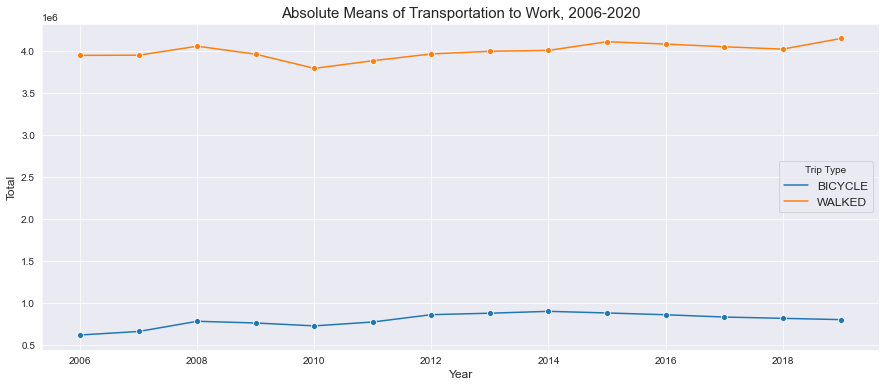

In [11]:
# plot absolute trips over full year range
f, ax = plt.subplots(1, figsize=(15,6))

sns.lineplot(
    data=means_transpo, 
    x="YEAR", 
    y="TRIPS", 
    hue="MODE",
    marker="o",
    ax=ax
)

plt.legend(title="Trip Type", fontsize=12)
ax.set_title("Absolute Means of Transportation to Work, 2006-2020", size=15)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Total", fontsize=12)

Text(0, 0.5, 'Percent')

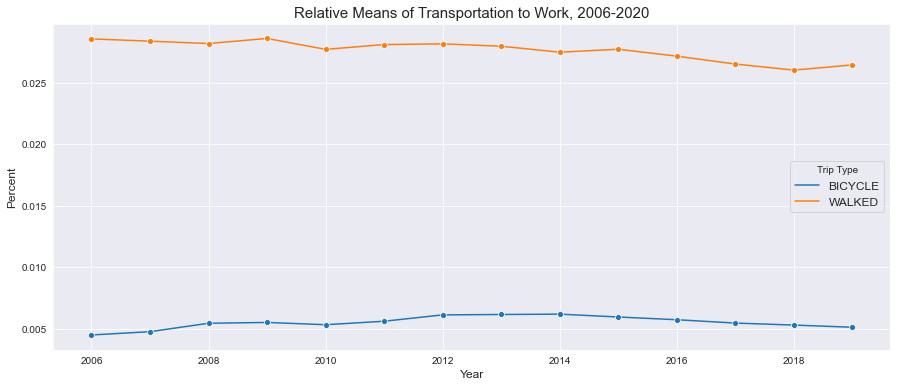

In [12]:
# plot absolute trips over full year range
f, ax = plt.subplots(1, figsize=(15,6))

sns.lineplot(
    data=means_transpo, 
    x="YEAR", 
    y="P_TRIPS", 
    hue="MODE",
    marker="o",
    ax=ax
)

plt.legend(title="Trip Type", fontsize=12)
ax.set_title("Relative Means of Transportation to Work, 2006-2020", size=15)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Percent", fontsize=12)